In [1357]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
(df_gamma_spread5.groupby('episode').aggregate('sum')['step_pnl'] -df_gamma_spread0.groupby('episode').aggregate('sum')['step_pnl']).std()

16.288736476019483

In [42]:
df_gamma_spread0.groupby('episode').aggregate('sum')['step_pnl'].std()

976.7067190169911

In [35]:
from environment import utils
from importlib import reload
reload(utils)
hedge_swaption, liab_swaption, _hedge_swap, liab_swap, liab_swaption_position, cov_hed_all, cov_liab_all, ttm_mat = utils.Utils().generate_swaption_market_data()
hedge_swap_ep = _hedge_swap[0]

utils initiated with spread=0, poisson_rate=1, n_episodes=1000

Memory usage before lmm: 371.40 MB
t_max set to 7
!!!! CONTRACT SIZE IS  1000.0

XXXXXXXXXXXXXXXXXXXXXX
 The spread is 0   
 nXXXXXXXXXXXXXXXXXXXXXX
Memory usage after: 371.40 MB

Memory usage after gc: 371.40 MB

Using  data/excited/20250508-212209_4y dataset


In [36]:
import numpy as np
np.mean(hedge_swaption[1:100,0,0,-1]*hedge_swaption[1:100,0,0,3]*0.02)

0.0002835374

In [37]:
np.mean(_hedge_swap[1:100,0,0,3])

0.04825143

In [38]:
np.mean(hedge_swaption[1:100,0,0,0])

0.014238279

In [39]:
np.mean(hedge_swaption[1:100,:,0,-1])

0.2416779

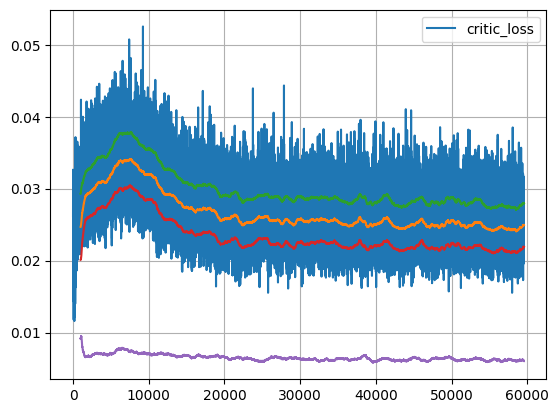

old


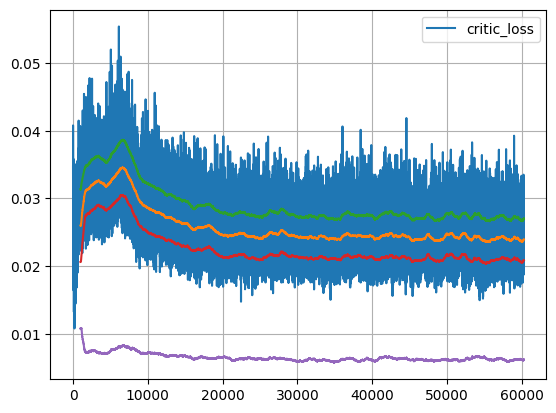

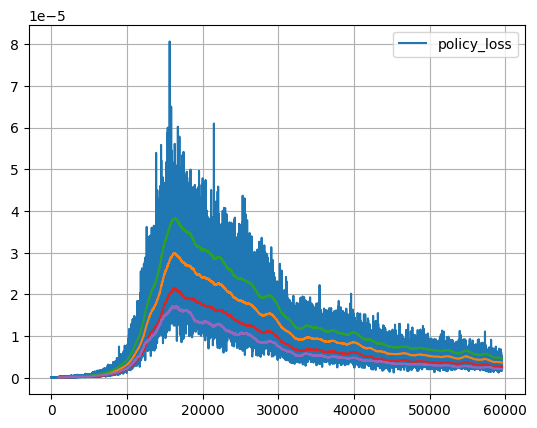

old


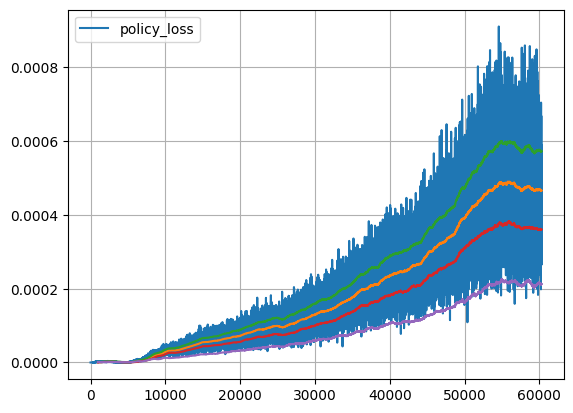

In [1887]:
import pandas as pd 
time_pure_log = '123128'
time= '134101'
df = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/learner/logs.csv')
df_eval = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv')
time = '111647'
df_old = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/learner/logs.csv')
df_train = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/train_loop/logs.csv'
                    )
df_eval_old = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
                    )
#df_eval = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
#                    )
import matplotlib.pyplot as plt
plt.clf()
#typ = 'policy'
typ = 'critic'
def plot_loss(typ,df):
    df[f'{typ}_loss'].plot() 
    mean = df[f'{typ}_loss'].rolling(window=1000).mean()
    std = df[f'{typ}_loss'].rolling(window=1000).std()
    plt.plot(mean)
    plt.plot(mean+std)
    plt.plot(mean-std)
    plt.plot(std*2)
    plt.plot()
    plt.grid()
    plt.legend()
    plt.show()

plot_loss('critic',df)
print("old")
plot_loss('critic',df_old)

plot_loss('policy',df)
print("old")
plot_loss('policy',df_old)
#plt.clf()
#df['critic_loss'].plot()
#plt.legend()
#df_train['episode_return'].plot()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

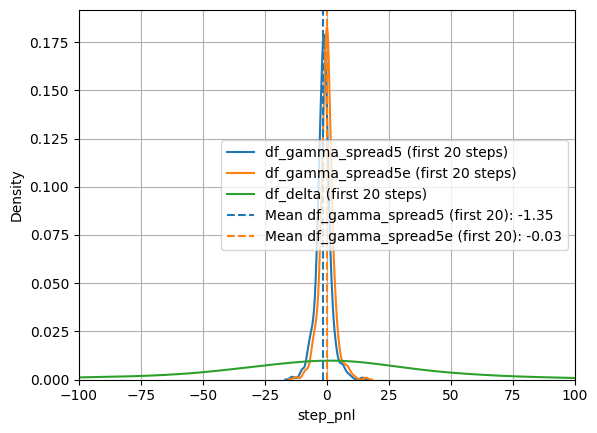

In [15]:
df_gamma_spread5 = pd.read_csv('/home/hedge/gamma-vega-rl-hedging/logs/greekhedge_spread=0.05/minimal/gamma/logs/eval_env/logs.csv')
df_gamma_spread5e = pd.read_csv('/home/hedge/gamma-vega-rl-hedging/logs/greekhedge_spread=0.0/minimal/gamma/logs/eval_env/logs.csv')
df_delta = pd.read_csv('/home/hedge/gamma-vega-rl-hedging/logs/greekhedge_spread=0.0/minimal/delta/logs/eval_env/logs.csv')
#df_gamma_spread0 = pd.read_csv('/home/hedge/gamma-vega-rl-hedging/logs/greekhedge_spread=0.0/logs/eval_env/logs.csv')
#df_eval = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
#                    )
plt.clf()
#sns.kdeplot(df_eval_old.groupby('episode').aggregate('sum')['step_pnl'])
#sns.kdeplot(df_eval.groupby('episode').aggregate('sum')['step_pnl'])
# Filter data for first 20 steps and aggregate
pnl_gamma_spread5_first20 = df_gamma_spread5[df_gamma_spread5['t'] < 20].groupby('episode')['step_pnl'].sum()
pnl_gamma_spread5e_first20 = df_gamma_spread5e[df_gamma_spread5e['t'] < 20].groupby('episode')['step_pnl'].sum()
pnl_delta_first20 = df_delta[df_delta['t'] < 20].groupby('episode')['step_pnl'].sum()

# Plot KDEs
sns.kdeplot(pnl_gamma_spread5_first20, label='df_gamma_spread5 (first 20 steps)')
sns.kdeplot(pnl_gamma_spread5e_first20, label='df_gamma_spread5e (first 20 steps)')
sns.kdeplot(pnl_delta_first20, label='df_delta (first 20 steps)')

# Plot vertical lines for means and quantiles
# Matching axvline color with kdeplot color for df_gamma_spread5
mean_val_gs5 = pnl_gamma_spread5_first20.mean()
plt.axvline(mean_val_gs5, color=sns.color_palette()[0], linestyle='--',
             label=f'Mean df_gamma_spread5 (first 20): {mean_val_gs5:.2f}')

# Matching axvline colors with kdeplot color for df_gamma_spread5e
mean_val_gs5e = pnl_gamma_spread5e_first20.mean()
plt.axvline(mean_val_gs5e, color=sns.color_palette()[1], linestyle='--',
             label=f'Mean df_gamma_spread5e (first 20): {mean_val_gs5e:.2f}')

# quantile_val_gs5e = pnl_gamma_spread5e_first20.quantile(0.05)
# plt.axvline(quantile_val_gs5e, color=sns.color_palette()[1], linestyle=':',
#             label=f'0.05 Quantile df_gamma_spread5e (first 20): {quantile_val_gs5e:.2f}')
#df_gamma_spread5[]
plt.legend()
plt.xlim(-100,100)
plt.grid()
plt.show()

In [1918]:
import numpy as np
print(np.mean(df_eval.groupby('episode').aggregate('sum')['cost_swaption_hed']))
print(np.mean(df_gamma_spread5.groupby('episode').aggregate('sum')['cost_swaption_hed']))

-0.011809687120970122
-0.02836780632072552


In [1922]:
np.mean(df_eval.groupby('episode').quantile(0.05)['step_pnl'])
print(np.mean(df_gamma_spread5e.groupby('episode').quantile(0.05)['step_pnl'])-np.mean(df_gamma_spread5.groupby('episode').quantile(0.05)['step_pnl']))
np.mean(df_gamma_spread5.groupby('episode').quantile(0.05)['step_pnl'])

-0.0008242352869747283


-0.28393151339969197

In [1872]:
np.mean(df_eval_old.groupby('episode').quantile(0.05)['step_pnl'])

-0.16553054785331553

In [1947]:
df_gamma_spread5e.groupby('episode').aggregate('sum')['step_pnl'].mean()*100-df_gamma_spread5.groupby('episode').aggregate('sum')['step_pnl'].mean()*100

3.0532041526842257